In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

In [2]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)

In [3]:
# Load the data

Auto = load_data('Auto')
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86,2790,15.6,82,1
vw pickup,44.0,4,97.0,52,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84,2295,11.6,82,1


In [4]:
# We can also impute the missing values of "horsepower" as we did previously

Auto['horsepower'].replace('?','104',inplace=True)
Auto['horsepower'] = pd.to_numeric(Auto['horsepower'])

C:\Users\kate\AppData\Local\Temp\ipykernel_11108\20472145.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Auto['horsepower'].replace('?','104',inplace=True)


In [5]:
# We will use the numeric variables in the data to predict mpg

X = Auto[['cylinders','displacement','horsepower','weight','acceleration','year','origin']]
y = Auto['mpg']

In [6]:
# Create train and test split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=314,
                                                    test_size=0.25,
                                                    shuffle=True) 
Train = pd.merge_ordered(X_train,y_train,left_on=X_train.index,right_on=y_train.index).drop(columns=['key_0'])
Test = pd.merge_ordered(X_test,y_test,left_on=X_test.index,right_on=y_test.index).drop(columns=['key_0'])

X_train

,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,
hi 1200d,8,304.0,193,4732,18.5,70,1
chevrolet chevelle malibu classic,6,250.0,100,3781,17.0,74,1
volkswagen type 3,4,97.0,54,2254,23.5,72,2
buick opel isuzu deluxe,4,111.0,80,2155,14.8,77,1
amc concord,6,232.0,90,3210,17.2,78,1
...,...,...,...,...,...,...,...
ford country squire (sw),8,400.0,170,4746,12.0,71,1
subaru,4,97.0,67,2065,17.8,81,3
volkswagen rabbit,4,97.0,71,1825,12.2,76,2


## A Single Regression Tree

In [7]:
# Build a single tree with depth 3

tree1 = DTR(max_depth=3)
tree1.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


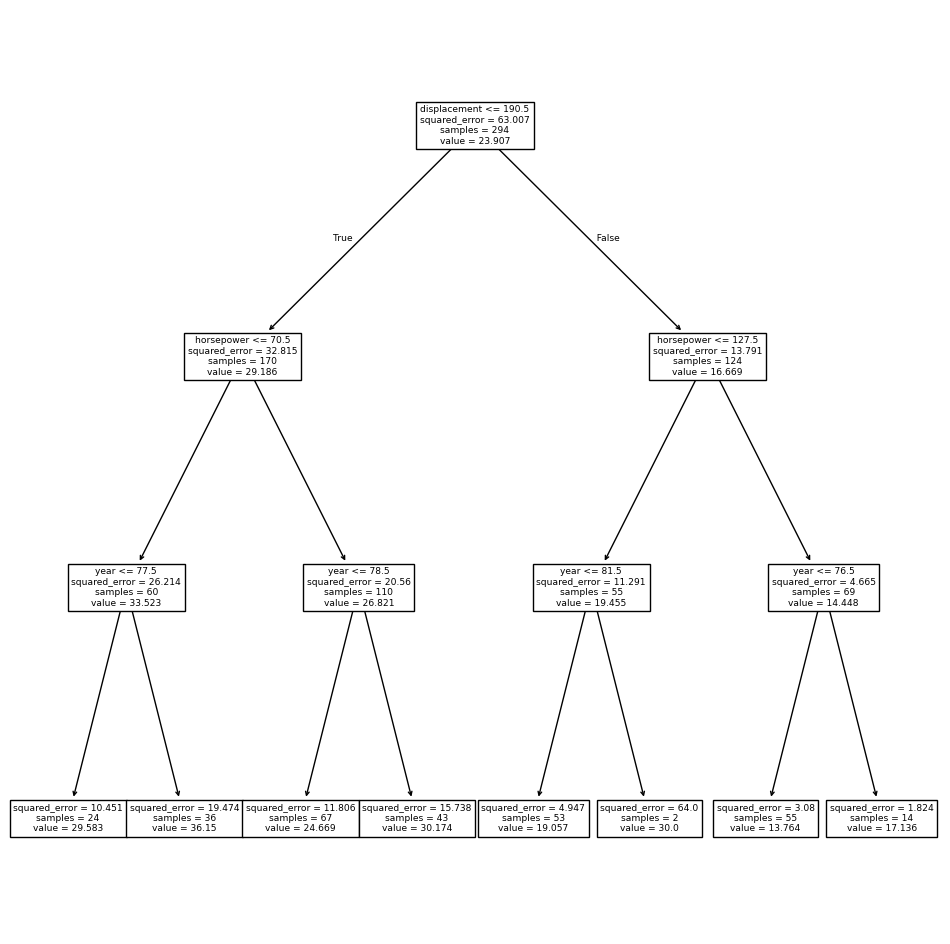

In [8]:
# Construct a graph of the tree

feature_names = list(X_train.columns)
ax = subplots(figsize=(12,12))[1]
plot_tree(tree1,
          feature_names=feature_names,
          ax=ax);

In [9]:
# Build a single tree with depth 3 BUT make sure each leaf has at least 10 records

tree2 = DTR(max_depth=3, min_samples_leaf=10)
tree2.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


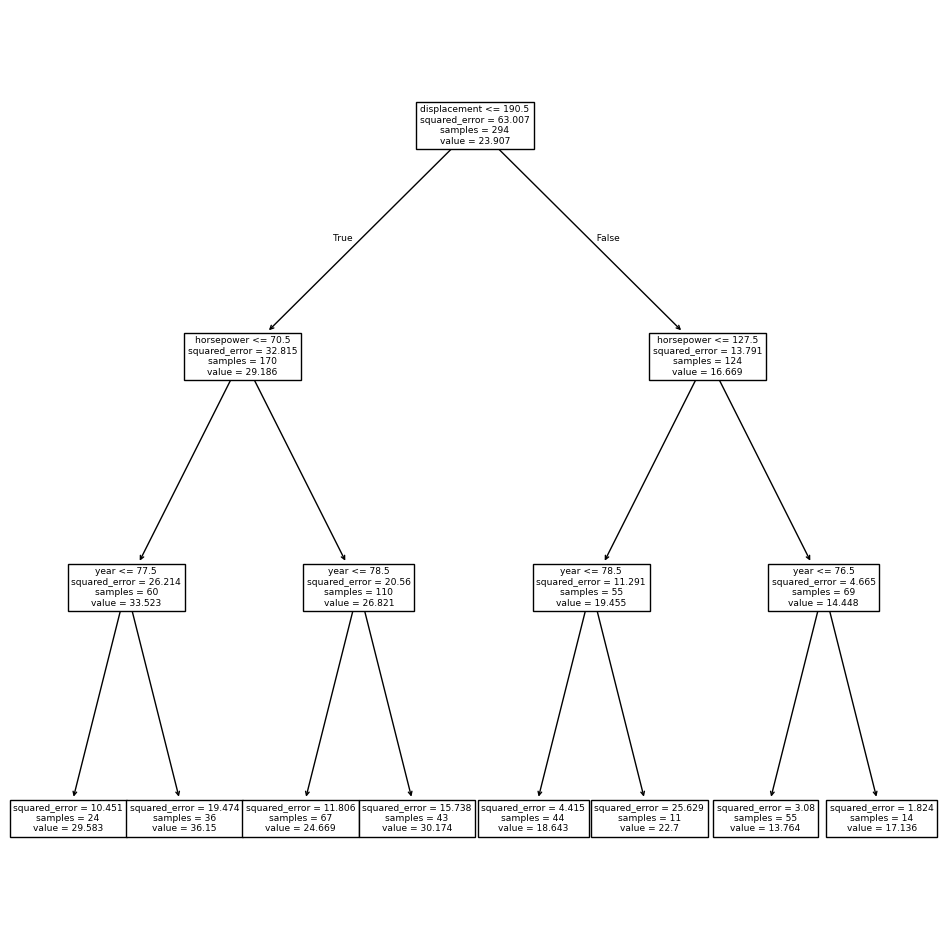

In [10]:
# Construct a graph of the tree

feature_names = list(X_train.columns)
ax = subplots(figsize=(12,12))[1]
plot_tree(tree2,
          feature_names=feature_names,
          ax=ax);

In [11]:
# Build a tree with 7 nodes (instead of depth=3)

tree3 = DTR(max_leaf_nodes=7)
tree3.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,7
,min_impurity_decrease,0.0
,ccp_alpha,0.0


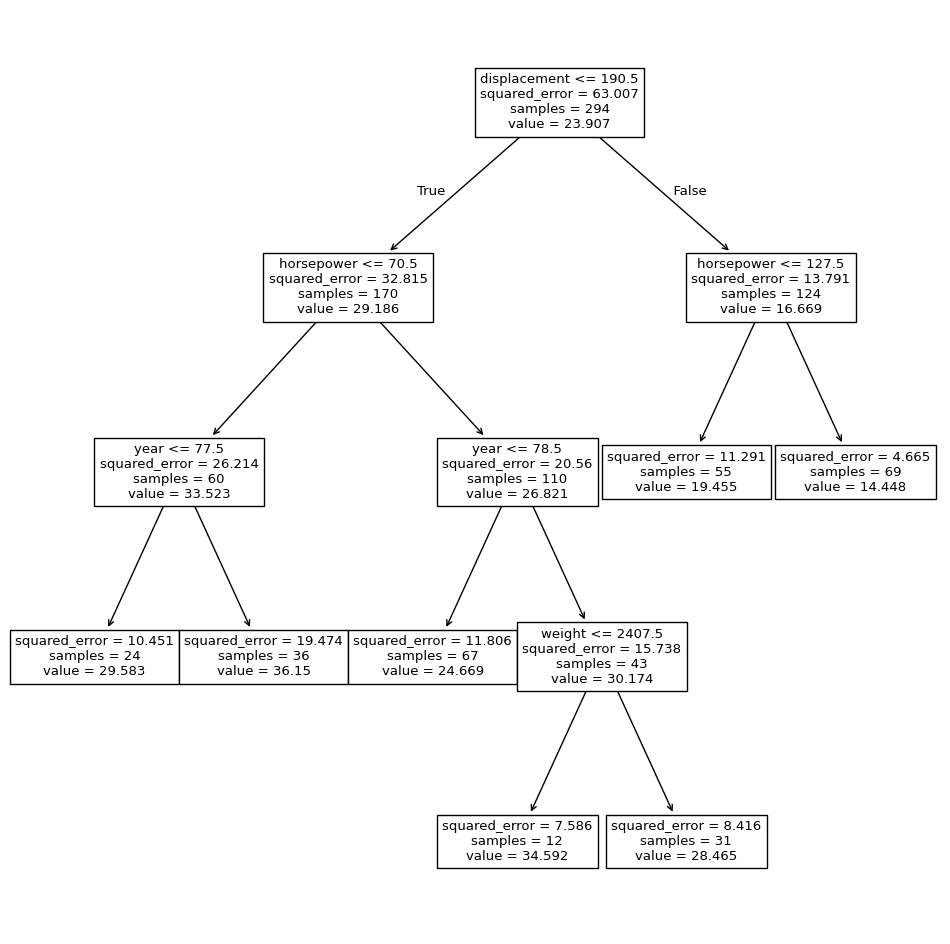

In [12]:
# Construct a graph of the tree

feature_names = list(X_train.columns)
ax = subplots(figsize=(12,12))[1]
plot_tree(tree3,
          feature_names=feature_names,
          ax=ax);

## Random Forest

In [77]:
# Build the model
# Documentation: https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html

rf_auto = RF(max_features=6,
             n_estimators=10000,
             #max_depth=10,
             min_samples_leaf=8,
             #max_leaf_nodes=15,
             bootstrap=True,
             n_jobs=10,
             random_state=314)
rf_auto.fit(X_train, y_train)

,n_estimators,10000
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,8
,min_weight_fraction_leaf,0.0
,max_features,6
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [78]:
# MSE

y_hat_rf = rf_auto.predict(X_test)
mse_rf = np.mean((y_test - y_hat_rf)**2)
print('test mse: ',mse_rf)

test mse:  6.004067468992375


4.5752488130755316
4.575248813075531
4.575732577533234

In [19]:
# Feature importance list

feature_imp = pd.DataFrame(
    {'importance':rf_auto.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
displacement,0.246719
weight,0.215359
horsepower,0.169873
cylinders,0.156727
year,0.130121
acceleration,0.043175
origin,0.038025


In [ ]:
# Can you minimize the test MSE?
